In [1]:
# Required libraries
import os
import datetime as dt
import math
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(font_scale=1.5)

import nltk
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.decomposition import LatentDirichletAllocation

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

import scipy
from scipy.sparse import csr_matrix, find

In [2]:
# Constants
my_data = "../data"

## Import data

Set of legacy questions to train/test the model. Query loads questions where last modification date was last year.

Stackexchange query is https://data.stackexchange.com/stackoverflow/query/edit/847084

select Id, Score, ViewCount, CreationDate, LastActivityDate, title, tags, body
from Posts 
where (score > 100) and (LastActivityDate > '2017-04-01') 
and (LastActivityDate < '2018-04-01') and (PostTypeId = 1)

In [3]:
# Load data into Pandas dataframe
datafile = "QueryResultsOld.csv"
full_path = os.path.join(my_data, datafile)
df_questions = pd.read_csv(full_path)
print(df_questions.shape)

(15089, 8)


Other set of questions to use with the trained model

https://data.stackexchange.com/stackoverflow/query/edit/846505

select Id, Score, ViewCount, CreationDate, LastActivityDate, title, tags, body
from Posts 
where (score > 100) and (LastActivityDate > '2018-04-01') and (PostTypeId = 1)

In [4]:
# Load data into Pandas dataframe
datafile = "QueryResultsNew.csv"
full_path = os.path.join(my_data, datafile)
df_new_questions = pd.read_csv(full_path)
print(df_new_questions.shape)

(3865, 8)


Have a quick look on the content of the uploaded data.

In [5]:
# sample structure and content
print(df_questions.columns)
print(df_questions.loc[5000])

Index(['Id', 'Score', 'ViewCount', 'CreationDate', 'LastActivityDate', 'title',
       'tags', 'body'],
      dtype='object')
Id                                                            3269717
Score                                                             109
ViewCount                                                       39788
CreationDate                                      2010-07-17 00:39:24
LastActivityDate                                  2018-03-28 15:17:03
title               Moq: How to get to a parameter passed to a met...
tags                                                        <c#><moq>
body                <p>Imagine this class</p>\n\n<pre><code>public...
Name: 5000, dtype: object


### Tokenize words

This piece of code cleans up the HTML content, removes stop words and converts the remaining ones into a list of stems.
The result is a new column in the table with that list for each question.

In [6]:
from nltk.stem import SnowballStemmer

# Take only aplanumeric words, no punctuation signs
tokenizer = nltk.RegexpTokenizer('\w+')

# Prepare set of stopwords
stopWords = set(stopwords.words('english'))

# Define stemmer
snowball_stemmer = SnowballStemmer("english")

wordsFiltered = []
wordsArray = []

# Run stems tokelization
for html_text in df_questions['body'] + " " + df_questions['title']:
    soup = BeautifulSoup(html_text, "lxml").get_text()
    words = tokenizer.tokenize(soup.lower())
    his_words = ''
    for w in words:
        if w not in stopWords:
            stem = snowball_stemmer.stem(w)
            wordsFiltered.append(stem)
            his_words = his_words + ' ' + stem
    wordsArray.append(his_words)


In [7]:
# Add a column to the dataframe with the list of cleaned stems
df_questions['words'] = wordsArray

In [8]:
# Quickly check the results
df_questions.loc[5000]

Id                                                            3269717
Score                                                             109
ViewCount                                                       39788
CreationDate                                      2010-07-17 00:39:24
LastActivityDate                                  2018-03-28 15:17:03
title               Moq: How to get to a parameter passed to a met...
tags                                                        <c#><moq>
body                <p>Imagine this class</p>\n\n<pre><code>public...
words                imagin class public class foo privat handler ...
Name: 5000, dtype: object

The variabe wordsFiltered is a list with all the stems as they appear. It has duplicate entries.

In [9]:
print("Total number of stems {0}".format(len(wordsFiltered)))

words_freq = nltk.FreqDist(wordsFiltered)

print("Total number of unique stems {0}".format(len(words_freq)))

Total number of stems 975465
Total number of unique stems 40992


In [10]:
wordsFiltered

['redirect',
 'https',
 'http',
 'opposit',
 'seem',
 'everyon',
 'teach',
 'server',
 'https',
 'paid',
 'ssl',
 'certif',
 'mirror',
 'keep',
 'around',
 'emerg',
 'merit',
 'get',
 'certif',
 'client',
 'desktop',
 'shortcut',
 'point',
 'http',
 'production_serv',
 'https',
 'production_serv',
 'work',
 'howev',
 'know',
 'product',
 'server',
 'goe',
 'dns',
 'forward',
 'kick',
 'client',
 'https',
 'shortcut',
 'stare',
 'https',
 'mirror_serv',
 'work',
 'big',
 'fat',
 'internet',
 'explor',
 '7',
 'red',
 'screen',
 'uneasy',
 'compani',
 'unfortun',
 'switch',
 'around',
 'client',
 'level',
 'user',
 'comput',
 'illiter',
 'like',
 'freak',
 'see',
 'https',
 'insecur',
 'error',
 'especi',
 'way',
 'firefox',
 '3',
 'internet',
 'explor',
 '7',
 'handl',
 'nowaday',
 'full',
 'stop',
 'kind',
 'thank',
 'help',
 'lol',
 'easi',
 'find',
 'apach',
 'solut',
 'http',
 'https',
 'redirect',
 'life',
 'opposit',
 'idea',
 'redirect',
 'https',
 'http',
 'time',
 'time',
 'see'

#### Have a look to the most common words (stems) used

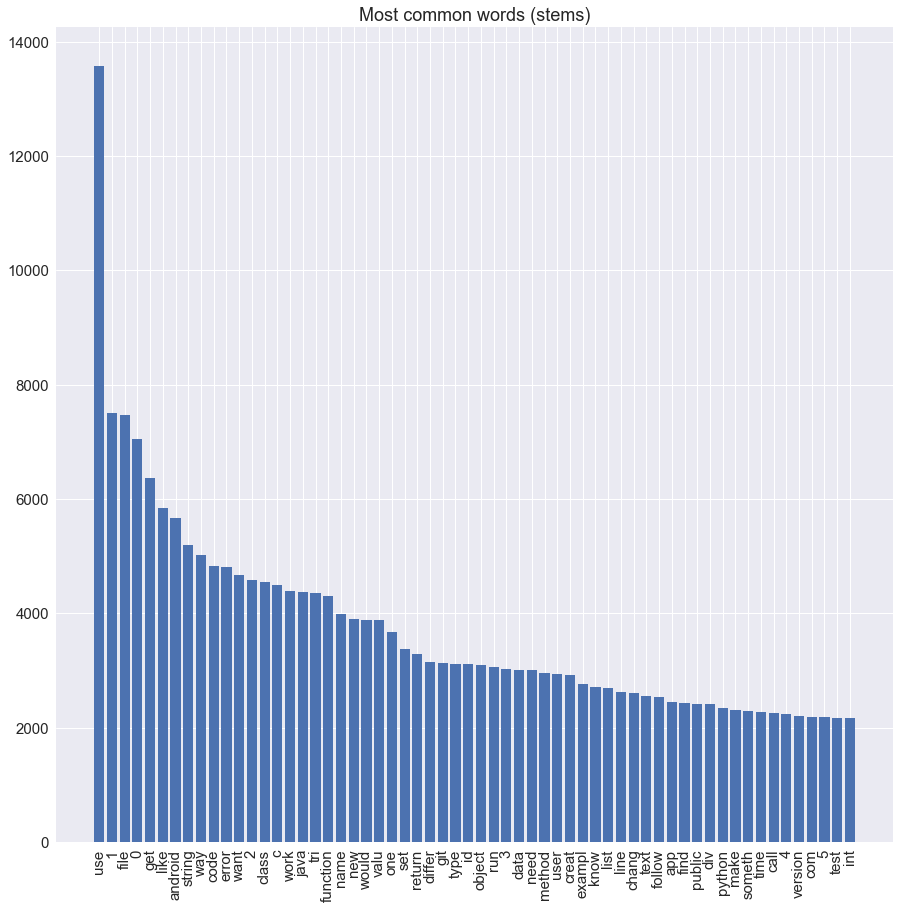

In [11]:
common_words = pd.DataFrame(words_freq.most_common(60))

# Histogram of the most common words
fig, ax = plt.subplots(figsize=(15, 15))
indexes = np.arange(len(common_words[0]))
values = common_words[1]
labels = common_words[0]
plt.bar(indexes, values)
plt.xticks(indexes, labels, rotation='vertical')
plt.title('Most common words (stems)', fontsize=18)
plt.show()

### Vectorize stems

The set of stems gets vectorized. Each question is a line of the matrix and each stem is a column. The values are the number of occurrences of each stem in each question.
Any word that is used in more than 95% of the questions or less than 5 times across all questions is removed, because its either too common or too specific to be used for the topic determination.

In [12]:
# Use vectorizer to create a matrix of monograms/bigrams
stem_vectorizer = CountVectorizer(lowercase = True, ngram_range=(1, 2), max_df=0.95, min_df=5)
stem_matrix = stem_vectorizer.fit_transform(df_questions['words'])

In [13]:
print("Remaining {1} stems for {0} questions after vectorization".format(stem_matrix.shape[0], stem_matrix.shape[1]))

Remaining 25507 stems for 15089 questions after vectorization


#### Statistics for number of remaining stems per question

In [14]:
print('Maximum number of stems per question: {0}'.format(stem_matrix.sum(1).max()))
print('Minimum number of stems per question: {0}'.format(stem_matrix.sum(1).min()))
print('Average number of stems per question: {0:.0f}'.format(stem_matrix.sum(1).mean()))
print('Average number of unique stems per question: {0:.0f}'.format(stem_matrix.getnnz(1).mean()))

Maximum number of stems per question: 2998
Minimum number of stems per question: 2
Average number of stems per question: 75
Average number of unique stems per question: 47


In [15]:
print(stem_matrix[15088])

  (0, 18067)	1
  (0, 17206)	9
  (0, 7905)	6
  (0, 16184)	1
  (0, 6105)	2
  (0, 15473)	3
  (0, 6544)	2
  (0, 2971)	2
  (0, 15193)	1
  (0, 12189)	8
  (0, 160)	1
  (0, 1793)	1
  (0, 3940)	1
  (0, 18054)	5
  (0, 18261)	1
  (0, 17998)	3
  (0, 4089)	1
  (0, 21128)	8
  (0, 297)	1
  (0, 15726)	6
  (0, 49)	3
  (0, 19209)	1
  (0, 4118)	1
  (0, 95)	1
  (0, 17176)	8
  :	:
  (0, 17185)	22
  (0, 21113)	9
  (0, 15595)	1
  (0, 18519)	2
  (0, 70)	3
  (0, 8638)	1
  (0, 14533)	1
  (0, 17663)	1
  (0, 7693)	1
  (0, 13092)	1
  (0, 16872)	3
  (0, 22076)	2
  (0, 8717)	17
  (0, 11076)	2
  (0, 18231)	1
  (0, 22846)	5
  (0, 14781)	3
  (0, 15500)	2
  (0, 8402)	2
  (0, 10330)	1
  (0, 9866)	1
  (0, 8762)	1
  (0, 6863)	2
  (0, 16311)	1
  (0, 9035)	1


In [16]:
print(stem_vectorizer.vocabulary_)

{'redirect': 17718, 'https': 10222, 'http': 10154, 'opposit': 15488, 'seem': 19058, 'everyon': 7171, 'teach': 21361, 'server': 19286, 'paid': 15814, 'ssl': 20301, 'certif': 3111, 'mirror': 13766, 'keep': 11664, 'around': 1830, 'emerg': 6657, 'merit': 13530, 'get': 9035, 'client': 3632, 'desktop': 5676, 'shortcut': 19615, 'point': 16311, 'work': 24928, 'howev': 10021, 'know': 11770, 'product': 16798, 'goe': 9521, 'dns': 6188, 'forward': 8635, 'kick': 11756, 'big': 2361, 'fat': 7676, 'internet': 11095, 'explor': 7506, 'red': 17711, 'screen': 18812, 'compani': 4202, 'unfortun': 22648, 'switch': 21071, 'level': 12150, 'user': 23403, 'comput': 4297, 'like': 12221, 'see': 18993, 'insecur': 10794, 'error': 6863, 'especi': 7052, 'way': 24383, 'firefox': 8231, 'handl': 9718, 'nowaday': 14835, 'full': 8762, 'stop': 20519, 'kind': 11760, 'thank': 21623, 'help': 9866, 'easi': 6406, 'find': 8109, 'apach': 1508, 'solut': 19943, 'life': 12211, 'idea': 10330, 'ssl certif': 20303, 'work howev': 25000, 

Number of stems in the vectorized vocabulary

In [17]:
print('Number of stems in the vectorized vocabulary : {0}'.format(len(stem_vectorizer.vocabulary_)))

Number of stems in the vectorized vocabulary : 25507


### Vectorize tags

In [18]:
# All tags are kept in the vectorization, even the very frequent and very uncommon
tag_vectorizer = CountVectorizer(lowercase = True, max_df=1.0, min_df=0, token_pattern = '[^<>]+')
tag_matrix = tag_vectorizer.fit_transform(df_questions['tags'])
print(tag_matrix.shape)

(15089, 5443)


In [19]:
# Checking matrix has only ones or zeroes
tag_matrix.max()

1

In [20]:
tag_matrix.min()

0

In [21]:
print(tag_matrix)

  (0, 339)	1
  (0, 2270)	1
  (0, 3937)	1
  (0, 4486)	1
  (1, 700)	1
  (1, 1600)	1
  (1, 1791)	1
  (2, 700)	1
  (2, 1910)	1
  (2, 3714)	1
  (2, 4914)	1
  (3, 3)	1
  (3, 1585)	1
  (3, 2795)	1
  (4, 3124)	1
  (4, 4451)	1
  (4, 4892)	1
  (5, 700)	1
  (5, 2525)	1
  (6, 35)	1
  (6, 1573)	1
  (6, 2022)	1
  (6, 2372)	1
  (6, 3397)	1
  (7, 1127)	1
  :	:
  (15080, 8)	1
  (15080, 5173)	1
  (15081, 1240)	1
  (15081, 2548)	1
  (15081, 2599)	1
  (15081, 3054)	1
  (15082, 1127)	1
  (15082, 1798)	1
  (15083, 2548)	1
  (15083, 3240)	1
  (15084, 1144)	1
  (15084, 3495)	1
  (15084, 3823)	1
  (15085, 2525)	1
  (15085, 2528)	1
  (15085, 2535)	1
  (15085, 2699)	1
  (15086, 1415)	1
  (15087, 552)	1
  (15087, 1166)	1
  (15087, 2799)	1
  (15088, 2879)	1
  (15088, 3823)	1
  (15088, 3826)	1
  (15088, 4166)	1


Tag_matrix is composed only of ones (and zeroes but they are not physicall represented because it's a sparse matrix).

In [22]:
print('Total number of different tags: {0}'.format(tag_matrix.shape[1]))

Total number of different tags: 5443


In [23]:
print('Maximum number of tags per question: {0}'.format(tag_matrix.sum(1).max()))
print('Minimum number of tags per question: {0}'.format(tag_matrix.sum(1).min()))
print('Average number of tags per question: {0:.0f}'.format(tag_matrix.sum(1).mean()))

Maximum number of tags per question: 5
Minimum number of tags per question: 1
Average number of tags per question: 3


In [24]:
# Create a datraframe with the list of tags and the number of times they are used
tag_names = tag_vectorizer.get_feature_names()

tag_df = pd.DataFrame(tag_matrix.sum(0)).T
tag_df.rename(index=str, columns={0:'number'}, inplace=True)
tag_df['names'] = tag_names

In [25]:
tag_df

,number,names
0,2,.a
1,1,.bash-profile
2,18,.htaccess
3,543,.net
4,7,.net-2.0
5,13,.net-3.5
6,16,.net-4.0
7,6,.net-4.5
8,1,.net-4.5.2
9,4,.net-assembly


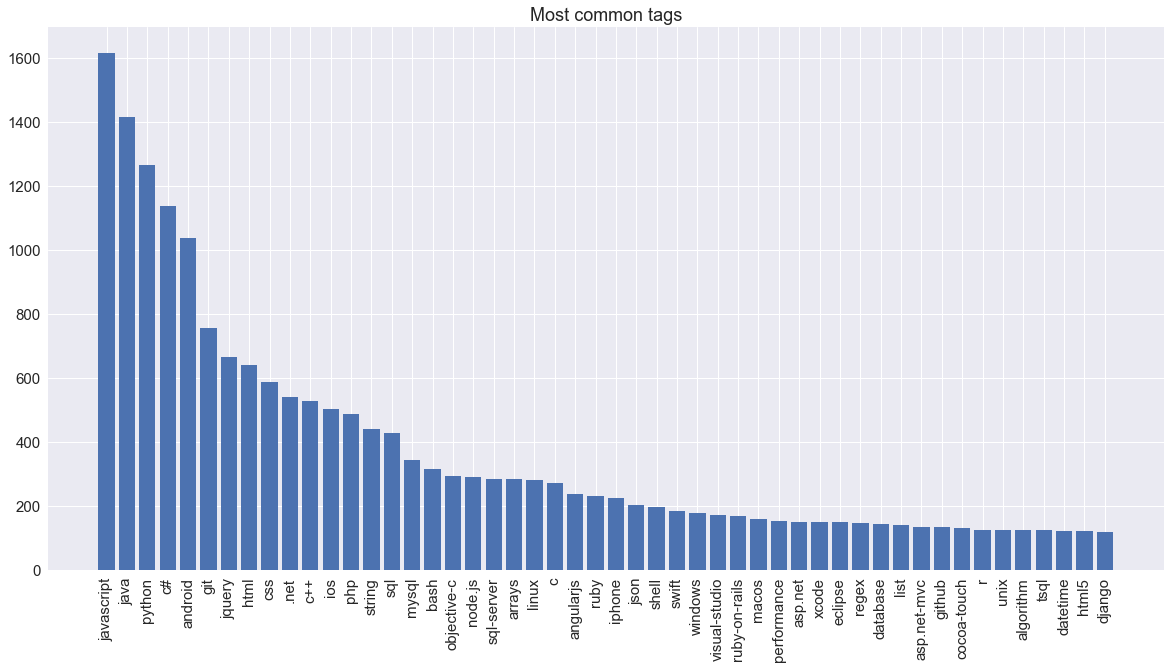

In [26]:
# Check tags distribution
fig, ax = plt.subplots(figsize=(20, 10))
top_tags = tag_df.sort_values(by='number', ascending=False).head(50)
indexes = np.arange(50)
values = top_tags['number']
labels = top_tags['names']
plt.bar(indexes, values)
plt.xticks(indexes, labels, rotation='vertical')
plt.title('Most common tags', fontsize=18)
plt.show()

In [27]:
# Get list of features (tags)
tf_feature_names = stem_vectorizer.get_feature_names()

### Explore topic engineering with Latent Dirichlet Allocation.

Checking score and perplexity for variable number of topics

In [28]:
for no_topics in np.arange(2, 90+1, 1):

    # Run LDA
    lda = LatentDirichletAllocation(n_topics=no_topics, max_iter=5, learning_method='online',
                                    learning_offset=50.,random_state=0)

    lda_corpus = lda.fit_transform(stem_matrix)
    print(lda.score(stem_matrix))
    print("Perplexity for {0} topics {1}".format(no_topics, lda.perplexity(stem_matrix)))

-9898556.45258
Perplexity for 2 topics 6467.355447362601
-10611956.7516
Perplexity for 3 topics 12172.230558766
-11393214.491
Perplexity for 4 topics 24329.726831004566
-12228135.1159
Perplexity for 5 topics 50999.19575585718
-13072883.6446
Perplexity for 6 topics 107838.2791941794
-13801401.934
Perplexity for 7 topics 205701.0377001139
-14631577.7337
Perplexity for 8 topics 429374.1787657536
-15516705.2611
Perplexity for 9 topics 941002.0567661058
-16406104.3209
Perplexity for 10 topics 2070092.0985811432
-17202303.3372
Perplexity for 11 topics 4192844.86512573
-18127161.1745
Perplexity for 12 topics 9518285.758173503
-19055770.7806
Perplexity for 13 topics 21679688.249578454
-19988406.9942
Perplexity for 14 topics 49556141.229406975
-20886422.6839
Perplexity for 15 topics 109853472.63079523
-21871003.6357
Perplexity for 16 topics 262939493.58533317
-22739581.8285
Perplexity for 17 topics 567857466.9791846
-23803233.3767
Perplexity for 18 topics 1457880123.8698769
-24887557.1237
Perpl

Observation : the perplexity strictly increases with the number of topics when tested between 2 and 90. It almost doubles with each additional topic. It's close to 1000*2^(ntopics-1).
The score doesn't change so much with the number of topics.

Another evaluation method is the rate of proposed tags that match with the real given ones.

In [29]:
# Run it once again with 20 topics to have a look into the topics

no_topics = 20
lda = LatentDirichletAllocation(n_topics=no_topics, max_iter=5, learning_method='online',
                                learning_offset=50.,random_state=0)

lda_corpus = lda.fit_transform(stem_matrix)


In [30]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()


In [31]:
n_top_words = 20
print_top_words(lda, tf_feature_names, n_top_words)

Topic #0: tabl select key valu id column databas sql queri row mysql name option null set data creat insert td user
Topic #1: class public java method object new system use error except static type void thread properti differ privat code get null
Topic #2: java com androidruntim nativ main activitythread zygoteinit regex nativ method error androidruntim activitythread java app activitythread android os lang reflect movi ch looper android intern method java captur
Topic #3: div imag class text css color click button use jqueri element style width html want page view display set li
Topic #4: use like would code way one work differ know time data need question want seem look exampl make get someth
Topic #5: git commit branch chang repositori remot file master push github local merg origin repo pull work updat want clone add
Topic #6: file error run line command tri get path window directori use python script user work test log open set folder
Topic #7: date 00 self 11 05 15 10 12 01 02 03

### Topic engineering using tf-idf

In [32]:
# Do a td-idf vectorization
n_features = 2000
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=5,
                                   max_features=n_features,
                                   stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(df_questions['words'])

# Extracto topics using Non-negative Matrix Factorization
n_components = 20
nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)

In [33]:
nmf.components_.shape

(20, 2000)

In [34]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

Topic #0: use code like way app user work know applic want set need view question imag make time chang someth look
Topic #1: git branch commit repositori master remot push chang merg github repo local pull origin clone checkout head histori rebas delet
Topic #2: string charact convert replac str char remov return split length contain like way hello int format substr integ concaten check
Topic #3: file directori folder path txt open delet read filenam upload exist copi creat content project batch write want download jar
Topic #4: android id layout_width wrap_cont layout_height textview activ studio button app xml fill_par layout view com apk color applic sdk linearlayout
Topic #5: div element css id html width text height jqueri imag style content button class page center click li background span
Topic #6: tabl sql column mysql databas queri row select server data insert id null key creat exist constraint record foreign count
Topic #7: array element php numpi convert int way arr loop in

td-idf is not so well adapted for the objective we are pursuing : propose tags for only one document. In this case it's difficult to calculate the inverse document frequency for just one document. Let's go back to LDA.

The LDA corpus matrix gives the probability for a document to belong to a topic.

In [35]:
# Check shape of generated matrix
lda_corpus.T.shape

(20, 15089)

In [36]:
# Look into one sample
lda_corpus[11]

array([  6.49350654e-04,   1.95669655e-02,   6.49350649e-04,
         6.49350654e-04,   1.98569680e-01,   6.49350657e-04,
         7.06958276e-01,   6.49350661e-04,   6.49350655e-04,
         6.49350652e-04,   6.49350650e-04,   6.49350649e-04,
         6.49350650e-04,   6.49350649e-04,   6.49350649e-04,
         6.45154687e-02,   6.49350649e-04,   6.49350670e-04,
         6.49350649e-04,   6.49350649e-04])

Create a matrix that gives the weight of each tag for each topic. Weight can be grater than 1 if a tag is used several times in a topic. It's then normalized to avoid tags being very much used to be too often proposed.

In [37]:
# Calculate matrix of weight of each tag for each topic.
topic_tag_weight = np.matmul(lda_corpus.T, tag_matrix.todense())

# Normalize the weight matrix to reduce the influence of the tags most used
topic_tag_weight_norm = topic_tag_weight / (topic_tag_weight.sum(axis = 1))

topic_tag_weight_norm.shape

(20, 5443)

In [38]:
# Convert matrix into dataframe to make it easier to handle
topic_tag_df = pd.DataFrame(topic_tag_weight_norm)

topic_tag_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,9.233314e-06,7.310624e-05,0.000013,6.621625e-07,5.635619e-05,1.994487e-06,1.388391e-04,1.344076e-05,7.197328e-05,0.000008,1.021170e-04,0.000008,2.629626e-06,0.000010,0.000011,4.036250e-07,0.000010,3.183632e-05,0.000023,2.770162e-06
1,7.163150e-07,4.604540e-07,0.000008,4.371067e-07,2.785961e-05,1.316601e-06,1.161288e-04,2.283446e-06,2.844087e-06,0.000005,2.222995e-06,0.000006,1.735869e-06,0.000006,0.000007,2.664410e-07,0.000007,1.329883e-06,0.000015,1.828639e-06
2,4.851727e-05,5.979711e-05,0.000378,2.545234e-04,6.615516e-04,4.733764e-05,6.504624e-04,7.535503e-05,4.280970e-03,0.000112,4.101416e-04,0.000061,2.833831e-04,0.000156,0.000082,2.549851e-05,0.001634,1.164315e-04,0.000164,4.873701e-05
3,9.173010e-03,2.349624e-02,0.007649,5.643410e-03,1.260788e-02,1.888984e-03,9.046477e-03,9.554973e-03,6.510551e-03,0.015257,7.683033e-03,0.025040,7.357450e-03,0.044869,0.009866,1.433678e-02,0.016407,1.167104e-02,0.010569,1.928859e-03
4,1.933361e-04,4.887583e-04,0.000026,4.758539e-05,1.147553e-04,2.134775e-05,1.198043e-04,1.858703e-05,6.309111e-05,0.000092,1.632175e-04,0.000115,2.493273e-05,0.000231,0.000023,2.020486e-04,0.000236,1.443944e-04,0.000089,5.647385e-06
5,3.507519e-04,5.951691e-04,0.000052,9.119067e-05,1.709999e-04,2.420761e-05,7.617729e-05,3.048549e-04,2.025778e-04,0.000996,4.625445e-05,0.000964,9.949768e-05,0.001250,0.000046,6.671383e-04,0.000215,3.017976e-05,0.000093,3.651291e-05
6,1.243749e-04,8.239720e-04,0.000130,1.316669e-04,2.970445e-04,1.356240e-05,6.241645e-04,1.369978e-04,1.927839e-04,0.000253,3.337809e-04,0.000218,1.037720e-04,0.000546,0.000099,2.060803e-04,0.001053,1.176761e-03,0.000256,4.060889e-05
7,1.132973e-06,4.857675e-04,0.000013,1.201171e-04,1.373039e-04,2.082426e-06,4.625609e-05,4.907078e-05,1.323921e-04,0.000009,9.471164e-06,0.000222,3.053139e-04,0.000833,0.000025,6.474056e-05,0.000065,1.120356e-04,0.000100,2.892302e-06
8,1.893339e-05,3.861873e-07,0.000007,1.137532e-04,1.298056e-07,1.104246e-06,1.121307e-05,1.915148e-06,2.385363e-06,0.000005,3.265932e-05,0.000447,1.455890e-06,0.000333,0.000006,2.234666e-07,0.000117,3.581553e-05,0.000013,1.533698e-06
9,1.207647e-05,9.100772e-05,0.000016,2.073993e-05,8.262271e-05,3.950108e-05,6.482364e-05,6.085579e-06,7.158164e-06,0.000011,3.085830e-06,0.000096,1.240525e-05,0.000571,0.000010,5.975467e-05,0.000162,9.261042e-04,0.000021,2.538409e-06


In [39]:
# List of tags per topic
for topic in np.arange(topic_tag_df.shape[0]):
    print('------------ topic {0} ---------------'.format(topic))
    for i in topic_tag_df.iloc[topic].argsort()[:-10:-1]:
        print(tag_df.iloc[i]['names'])

------------ topic 0 ---------------
sql
mysql
sql-server
c#
tsql
javascript
jquery
python
database
------------ topic 1 ---------------
java
c#
c++
.net
android
javascript
python
multithreading
c
------------ topic 2 ---------------
java
android
regex
python
javascript
c#
string
c++
.net
------------ topic 3 ---------------
css
html
javascript
jquery
android
ios
iphone
twitter-bootstrap
objective-c
------------ topic 4 ---------------
javascript
java
python
c#
android
c++
git
.net
html
------------ topic 5 ---------------
git
github
version-control
branch
git-branch
svn
git-merge
git-submodules
merge
------------ topic 6 ---------------
python
bash
linux
java
android
shell
c#
git
windows
------------ topic 7 ---------------
python
datetime
date
javascript
java
ios
sql
c#
objective-c
------------ topic 8 ---------------
ruby
python
ruby-on-rails
java
javascript
c#
matplotlib
android
ios
------------ topic 9 ---------------
java
javascript
c#
python
datetime
date
php
string
.net
-------

## Classify new questions

The new questions get vectorized with the same set of stems than the training set. If new terms/stems are included, they are just ignored.

In [40]:
newWordsFiltered = []
newWordsArray = []

for html_text in df_new_questions['body'] + " " + df_new_questions['title']:
    soup = BeautifulSoup(html_text, "lxml").get_text()
    words = tokenizer.tokenize(soup.lower())
    his_words = ''
    for w in words:
        if (w not in stopWords):
            stem = snowball_stemmer.stem(w)
            wordsFiltered.append(stem)
            his_words = his_words + ' ' + stem
    newWordsArray.append(his_words)

# Add a column to the dataframe with le list of cleaned stems
df_new_questions['stems'] = newWordsArray
stem_matrix_new = stem_vectorizer.transform(df_new_questions['stems'])

In [41]:
df_new_questions.shape

(3865, 9)

In [42]:
df_new_questions

,Id,Score,ViewCount,CreationDate,LastActivityDate,title,tags,body,stems
0,8692,190,213093,2008-08-12 11:28:36,2018-04-17 11:32:54,How to use Xpath in Python?,<python><xml><dom><xpath><nodes>,<p>What is the library? Is there a full implem...,librari full implement librari use websit use...
1,10752,250,42186,2008-08-14 06:27:57,2018-04-16 20:15:33,What is the difference between integration and...,<unit-testing><integration-testing>,<p>I know the so-called textbook definition of...,know call textbook definit unit test integr t...
2,24816,537,560391,2008-08-24 02:52:42,2018-04-20 17:56:57,Escaping HTML strings with jQuery,<javascript><jquery><string><escaping>,<p>Does anyone know of an easy way to escape H...,anyon know easi way escap html string jqueri ...
3,24678,129,96714,2008-08-23 22:42:50,2018-04-05 06:40:55,JavaScript editor within Eclipse,<javascript><eclipse><plugins><editor>,<p>I'm looking for the best JavaScript editor ...,look best javascript editor avail eclips plug...
4,25259,230,32374,2008-08-24 18:21:11,2018-04-18 21:39:01,How does Stack Overflow generate its SEO-frien...,<regex><language-agnostic><seo><friendly-url><...,"<p>What is a good complete <a href=""http://en....",good complet regular express process would ta...
5,1720320,224,207375,2009-11-12 06:35:27,2018-04-03 10:04:20,How to dynamically create CSS class in JavaScr...,<javascript><css><stylesheet>,<p>I need to create a CSS stylesheet class dyn...,need creat css stylesheet class dynam javascr...
6,1720421,1543,1274493,2009-11-12 07:04:09,2018-04-19 15:17:45,How to concatenate two lists in Python?,<python><list>,<p>How do I concatenate two lists in Python?</...,concaten two list python exampl liston 1 2 3 ...
7,26141731,134,107621,2014-10-01 12:45:56,2018-04-16 16:05:56,Launch Image does not show up in my iOS App,<ios8><xcode6><xcasset><launchimage>,<p>I want to get a simple launch screen to sho...,want get simpl launch screen show app built u...
8,9950144,117,33848,2012-03-30 20:40:07,2018-04-11 19:38:00,Access lapply index names inside FUN,<r><lapply><names><indices>,<p>Is there a way to get the list index name i...,way get list index name lappli function n nam...
9,26143315,142,72537,2014-10-01 14:05:55,2018-04-23 06:17:13,Laravel 5 - artisan seed [ReflectionException]...,<laravel><composer-php><laravel-5><artisan>,<p>When I run <strong>php artisan db:seed</str...,run php artisan db seed get follow error refl...


In [43]:
print(stem_matrix_new)

  (0, 8762)	1
  (0, 10511)	1
  (0, 12178)	2
  (0, 12205)	1
  (0, 17185)	1
  (0, 22846)	2
  (0, 23401)	1
  (0, 24646)	1
  (0, 24648)	1
  (0, 25435)	1
  (1, 653)	1
  (1, 654)	1
  (1, 797)	2
  (1, 1083)	1
  (1, 1401)	2
  (1, 1420)	1
  (1, 2289)	1
  (1, 2292)	1
  (1, 2356)	1
  (1, 2407)	1
  (1, 2843)	1
  (1, 3423)	7
  (1, 3513)	1
  (1, 3524)	1
  (1, 3583)	1
  :	:
  (3864, 2746)	1
  (3864, 3132)	2
  (3864, 4633)	1
  (3864, 5490)	1
  (3864, 7769)	1
  (3864, 8638)	1
  (3864, 8781)	1
  (3864, 10640)	4
  (3864, 10947)	1
  (3864, 13824)	3
  (3864, 16530)	1
  (3864, 18828)	1
  (3864, 19058)	1
  (3864, 19111)	1
  (3864, 20131)	1
  (3864, 20876)	2
  (3864, 20877)	2
  (3864, 21071)	1
  (3864, 21161)	1
  (3864, 21517)	2
  (3864, 21528)	1
  (3864, 21724)	1
  (3864, 22846)	1
  (3864, 23298)	1
  (3864, 25473)	1


In [44]:
print("New questions stem matrix shape: {0}".format(stem_matrix_new.shape))

New questions stem matrix shape: (3865, 25507)


In [45]:
stem_matrix.shape

(15089, 25507)

In [46]:
# Get probability of new questions to belong to a given topic
lda_new_corpus = lda.transform(stem_matrix_new)

In [47]:
lda_new_corpus[1500]

array([  2.57731967e-04,   5.75426605e-02,   2.57731962e-04,
         4.66642299e-02,   2.58415642e-01,   1.08432173e-02,
         3.69943361e-01,   2.57731959e-04,   1.12137310e-02,
         2.57731959e-04,   9.04838049e-02,   3.10664390e-02,
         2.57731959e-04,   2.57731964e-04,   2.57731959e-04,
         2.26970306e-02,   2.57731959e-04,   9.85525643e-02,
         2.57731960e-04,   2.57731961e-04])

In [48]:
print(lda_new_corpus.shape)
print(topic_tag_weight.shape)

(3865, 20)
(20, 5443)


In [49]:
# Calculate matrix of tags probability per new question
new_questions_tags = lda_new_corpus.dot(topic_tag_weight_norm)

In [50]:
new_questions_tags.shape

(3865, 5443)

In [51]:
new_questions_df = pd.DataFrame(new_questions_tags)

In [52]:
for question in np.arange(2000, 2010):
    print('---------------------------')
    print(df_new_questions.iloc[question][['title','body','tags']])
    proposed_tags = ''
    for i in new_questions_df.iloc[question].argsort()[:-10:-1]:
        proposed_tags += (tag_df.iloc[i]['names']) + " "
    print(proposed_tags)

---------------------------
title    Simplest way to serve static data from outside...
body     <p>I have a Java web application running on To...
tags           <tomcat><java-ee><servlets><static-content>
Name: 2000, dtype: object
java javascript c# python android .net html css jquery 
---------------------------
title      How to install Python MySQLdb module using pip?
body     <p>How can I install the <a href="http://mysql...
tags                                  <python><mysql><pip>
Name: 2001, dtype: object
node.js python javascript npm java android c# macos ios 
---------------------------
title                              Java OCR implementation
body     <p>This is primarily just curiosity, but are t...
tags                                           <java><ocr>
Name: 2002, dtype: object
java javascript c# python android c++ .net jquery git 
---------------------------
title              Dependency Injection vs Factory Pattern
body     <p>Most of the examples quoted for usage of

In [63]:
# Create matrix of tags for new questions
tag_matrix_new = tag_vectorizer.fit_transform(df_new_questions['tags'])
print(tag_matrix_new.shape)

(3865, 2616)


In [64]:
# Create dataframe of tags per new questions
tag_df_new_questions = pd.DataFrame(tag_matrix_new.sum(0)).T
tag_df_new_questions.rename(index=str, columns={0:'number'}, inplace=True)
tag_names_new = tag_vectorizer.get_feature_names()
tag_df_new_questions['names'] = tag_names_new

In [65]:
df_new_questions['tags'].head(10)

0                     <python><xml><dom><xpath><nodes>
1                  <unit-testing><integration-testing>
2               <javascript><jquery><string><escaping>
3               <javascript><eclipse><plugins><editor>
4    <regex><language-agnostic><seo><friendly-url><...
5                        <javascript><css><stylesheet>
6                                       <python><list>
7                 <ios8><xcode6><xcasset><launchimage>
8                          <r><lapply><names><indices>
9          <laravel><composer-php><laravel-5><artisan>
Name: tags, dtype: object

In [66]:
for name in tag_df_new_questions.iloc[tag_matrix_new[1].indices]['names']:
    print(name)

integration-testing
unit-testing


In [67]:
new_questions_tags[0]

matrix([[  4.47269275e-05,   1.29086355e-05,   9.01967945e-04, ...,
           4.35449433e-05,   6.80291510e-06,   6.48283445e-05]])

In [68]:
# Sample check the quality of the result
for question in np.arange(10, 20):
    print('---------------------------')
    print(df_new_questions.iloc[question][['title','body','tags']])
    tag_array = tag_df_new_questions.iloc[tag_matrix_new[question].indices]['names'].values
    print(tag_array)
    proposed_tags = ''
    right_tags = 0
    for i in new_questions_df.iloc[question].argsort()[:-5-1:-1]:
        proposed_tag = tag_df.iloc[i]['names']
        proposed_tags += (proposed_tag) + " "
        if proposed_tag in tag_array:
            right_tags += 1
    print(proposed_tags)
    print(right_tags/len(tag_array))

---------------------------
title    Formatting a number with exactly two decimals ...
body     <p>I have this line of code which rounds my nu...
tags                 <javascript><rounding><decimal-point>
Name: 10, dtype: object
['decimal-point' 'rounding' 'javascript']
javascript python java c# css 
0.3333333333333333
---------------------------
title    Generating a drop down list of timezones with PHP
body     <p>Most sites need some way to show the dates ...
tags                                  <php><timezone><utc>
Name: 11, dtype: object
['utc' 'timezone' 'php']
sql python mysql sql-server javascript 
0.0
---------------------------
title    file_get_contents(): SSL operation failed with...
body     <p>I’ve been trying to access this particular ...
tags                   <php><rest><ssl><file-get-contents>
Name: 12, dtype: object
['file-get-contents' 'ssl' 'rest' 'php']
javascript python java android c# 
0.0
---------------------------
title    ASP MVC in IIS 7 results in: HTTP E

In [69]:
# Add the list of prosed tags and the score per question to the dataframe
for question in np.arange(0, len(df_new_questions)):
    tag_array = tag_df_new_questions.iloc[tag_matrix_new[question].indices]['names'].values
    proposed_tags = ''
    right_tags = 0
    for i in new_questions_df.iloc[question].argsort()[:-5-1:-1]:
        proposed_tag = tag_df.iloc[i]['names']
        proposed_tags += (proposed_tag) + " "
        if proposed_tag in tag_array:
            right_tags += 1
    df_new_questions.loc[question,'right'] = (right_tags/len(tag_array))
    df_new_questions.loc[question,'proposed_tags'] = proposed_tags

In [70]:
# Example for one question
df_new_questions.loc[11]

Id                                                            1727077
Score                                                             115
ViewCount                                                       87894
CreationDate                                      2009-11-13 04:07:28
LastActivityDate                                  2018-04-14 23:00:49
title               Generating a drop down list of timezones with PHP
tags                                             <php><timezone><utc>
body                <p>Most sites need some way to show the dates ...
stems                site need way show date site user prefer time...
right                                                               0
proposed_tags                 sql python mysql sql-server javascript 
Name: 11, dtype: object

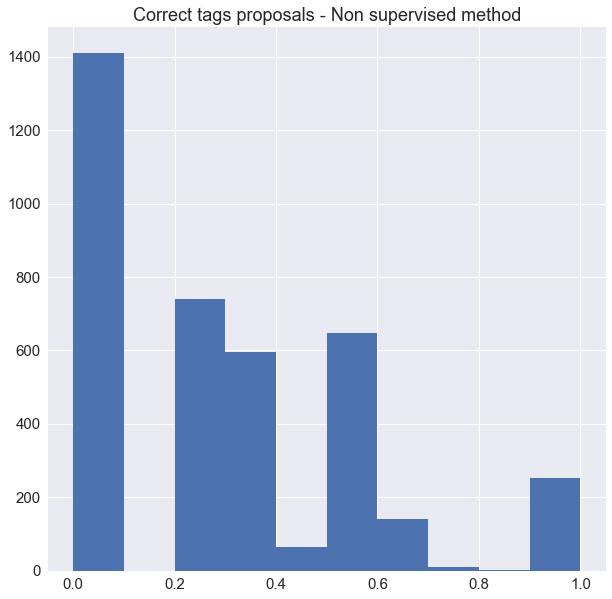

In [71]:
# Display distribution of correct ratio
fig, ax = plt.subplots(figsize=(10, 10))
plt.hist(df_new_questions['right'].dropna(), bins=10)
plt.title('Correct tags proposals - Non supervised method', fontsize=18)
plt.show()

In [72]:
# Calculate the number of questions for which at least 50% of the tags were proposed
unsupervised_score = df_new_questions[df_new_questions['right'] >= 0.5]['Id'].count() / len(df_new_questions)
print("Unsupervised methodology overall score {0}".format(unsupervised_score))

Unsupervised methodology overall score 0.2729624838292367


## Supervised methodology

In this approach, a multi-label SVC is used to get the probability for each question to have a given tag.<br>Features are the stem matriw per question.<br>Labels are the tags.

In [73]:
# Run multi-class classifier
X = stem_matrix
Y = tag_matrix

MultiLabelClassif = OneVsRestClassifier(SVC(kernel='linear', probability=True))
start = dt.datetime.now()
print("Start fitting {0}".format(start.strftime("%H:%M:%S")))
MultiLabelClassif.fit(X, Y)
end = dt.datetime.now()
print("End fitting {0}".format(end.strftime("%H:%M:%S")))
print("Fitting duration {0}".format(end - start) )

Start fitting 06:44:22


KeyboardInterrupt: 

In [ ]:
# Classify new questions
X_new = stem_matrix_new
new_predict = MultiLabelClassif.predict(X_new)

In [ ]:
# Get probabilities for a question to use a tag
new_predict_proba = MultiLabelClassif.predict_proba(X_new)

new_predict_proba.shape

In [ ]:
# Look into one sample
for values in new_predict_proba[11]:
    print (values)

In [ ]:
for question in np.arange(10, 20):
    print('---------------------------')
    print(df_new_questions.iloc[question][['title','body','tags']])
    tag_array = tag_df_new_questions.iloc[tag_matrix_new[question].indices]['names'].values
    print(tag_array)
    proposed_tags = ''
    right_tags = 0
    for i in new_predict_proba[question].argsort()[:-10-1:-1]:
        proposed_tag = tag_df.iloc[i]['names']
        proposed_tags += (proposed_tag) + " "
        if proposed_tag in tag_array:
            right_tags += 1
    print(proposed_tags)
    print(right_tags/len(tag_array))

In [ ]:
# Find the N most relevant tags for this question
for question in np.arange(0, len(df_new_questions)):
    tag_array = tag_df_new_questions.iloc[tag_matrix_new[question].indices]['names'].values
    proposed_tags = ''
    right_tags = 0
    for i in new_predict_proba[question].argsort()[:-5-1:-1]:
        proposed_tag = tag_df.iloc[i]['names']
        proposed_tags += (proposed_tag) + " "
        if proposed_tag in tag_array:
            right_tags += 1
    df_new_questions.loc[question,'right_supervised'] = (right_tags/len(tag_array))
    df_new_questions.loc[question,'proposed_tags_supervised'] = proposed_tags

In [ ]:
# Display distribution of correct ratio
fig, ax = plt.subplots(figsize=(10, 10))
plt.hist(df_new_questions['right_supervised'].dropna(), bins=10)
plt.title('Correct tags proposals - Supervised method', fontsize=18)
plt.show()

In [ ]:
# Calculate the number of questions for which at least 50% of the tags were proposed
df_new_questions[df_new_questions['right_supervised'] >= 0.5]['Id'].count() / len(df_new_questions)